# Covariates - Exports

In [176]:
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf 
from patsy import dmatrix 
import pandas as pd
import numpy as np

from utils import get_filtered_data, create_future_dataframe, plot_series

In [177]:
#Reading the data
df = get_filtered_data()

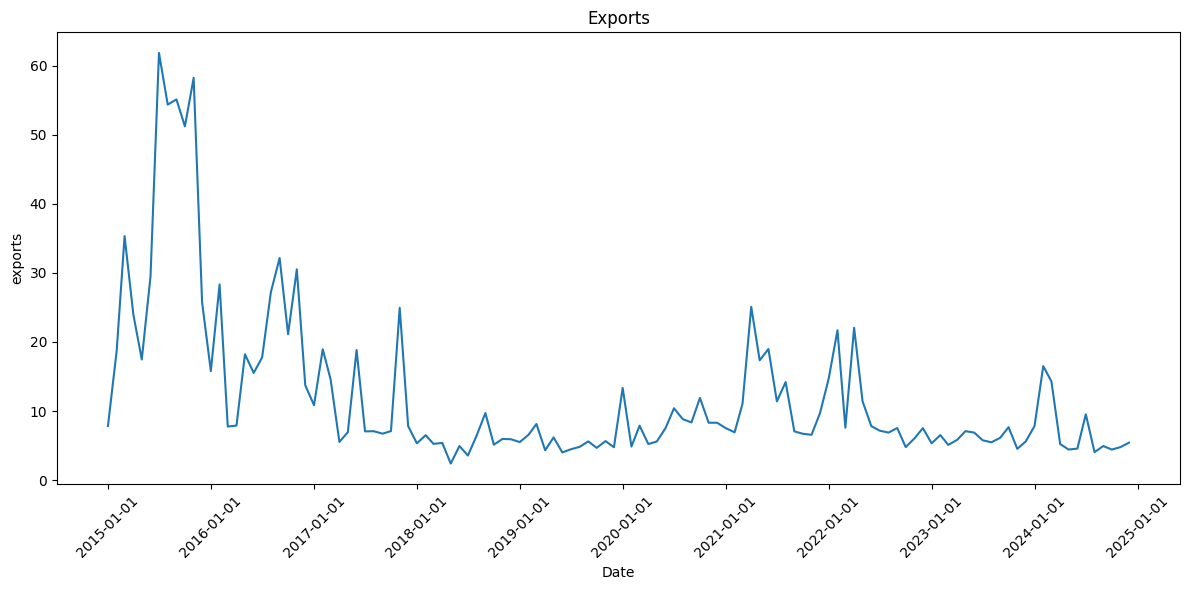

In [178]:
exports = df[['date', 'exports']] 
plot_series(exports, 'exports')

## Difficulties

Once again, we have a time-series that seems really odd and strange and quite difficult to understand and predict, like the `imports`. 

Linear models won't do the job. 

We, as well, can try a mix of a linear model with a non-linear trend, like it was done with `imports`. 

## Splines - Non-linear Model

In [179]:
exports = (
    exports
    .assign(
        t = range(len(exports)),
        month = exports["date"].dt.month
    )
)

exports_new = exports.copy()

# Fit linear regression with trend + seasonal dummies
model_exports_ols = smf.ols("exports ~ t + C(month)", data=exports).fit()

In [180]:
# Natural spline basis for trend
spline_basis = dmatrix("bs(t, df=8, degree=3, include_intercept=False)", 
                       {"t": exports["t"]}, return_type='dataframe')
# Give them simple names
spline_basis.columns = [f"spline_{i}" for i in range(spline_basis.shape[1])]

# Merge back
exports = pd.concat([exports, spline_basis], axis=1)

In [181]:
# Build formula with the expanded spline columns
formula = "exports ~ " + " + ".join(spline_basis.columns) + " + C(month)"
model_exports_splines = smf.ols(formula=formula, data=exports).fit()

In [182]:
model_exports_splines.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exports   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.42
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           3.32e-16
Time:                        23:33:10   Log-Likelihood:                -398.39
No. Observations:                 120   AIC:                             836.8
Df Residuals:                     100   BIC:                             892.5
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.8019      2.500      2.721      0.008       1.842      11.762
C(month)[T.2]      3.8493      3.281      1.173      0.243      -2.659      10.358
C(month)[T.3]      1.7876      3.286      0.544      0.588      -4.731       8.306
C(month)[T.4]      1.0528      3.292      0.320      0.750      -5.478       7.583
C(month)[T.5]     -0.2996      3.298     -0.091      0.928      -6.843       6.243
C(month)[T.6]      1.9210      3.304      0.581      0.562      -4.634       8.476
C(month)[T.7]      4.1079      3.309      1.241      0.217      -2.458      10.674
C(month)[T.8]      4.3633      3.314      1.316      0.191      -2.213      10.939
C(month)[T.9]      5.0290      3.320      1.515      0.133      -1.558      11.616
C(month)[T.10]     3.4929      3.327      1.050      0.296      -3.108      10.094
C(month)[T.11]     6.9445      3.337      2.081      0.040       0.325      13.564
C(month)[T.12]     1.2621      3.351      0.377      0.707      -5.386       7.910
spline_0           6.8019      2.500      2.721      0.008       1.842      11.762
spline_1          41.8969      9.033      4.638      0.000      23.975      59.818
spline_2         -12.3788      5.943     -2.083      0.040     -24.169      -0.589
spline_3          -5.6377      6.877     -0.820      0.414     -19.281       8.006
spline_4         -16.1006      5.913     -2.723      0.008     -27.832      -4.369
spline_5           4.1969      6.512      0.644      0.521      -8.724      17.117
spline_6         -18.0532      7.019     -2.572      0.012     -31.978      -4.128
spline_7          -3.0934      7.328     -0.422      0.674     -17.632      11.445
spline_8         -14.8413      6.919     -2.145      0.034     -28.569      -1.114
==============================================================================
Omnibus:                        9.342   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               18.901
Skew:                           0.190   Prob(JB):                     7.87e-05
Kurtosis:                       4.907   Cond. No.                     2.87e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.21e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Visualizing the Model Fit on Training Data

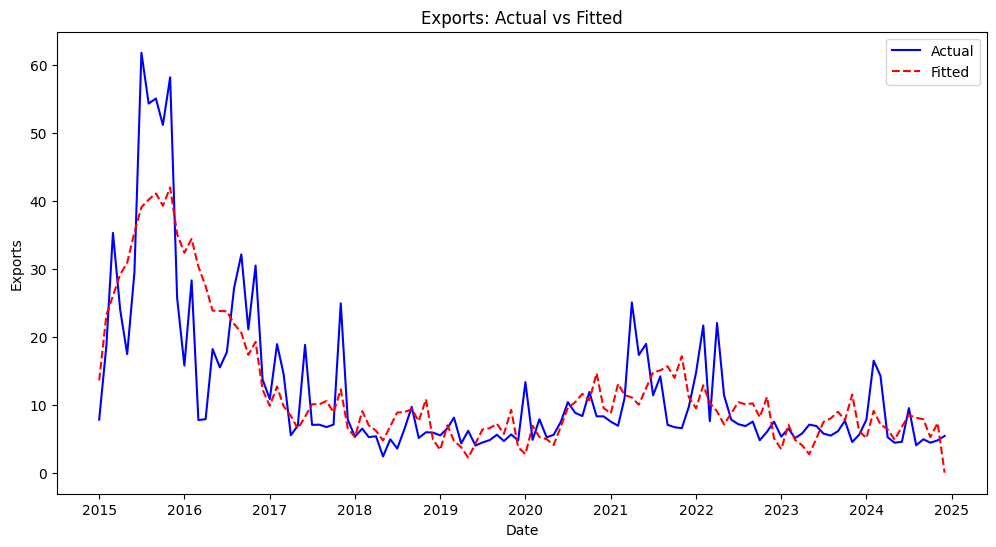

In [183]:
exports['fitted'] = model_exports_splines.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(exports["date"], exports["exports"], label="Actual", color="blue")
plt.plot(exports["date"], exports["fitted"], label="Fitted", color="red", linestyle="--")

plt.title("Exports: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Exports")
plt.legend()
plt.show()

## Visualizing the Predictions on the Test set

In [184]:
test_df = create_future_dataframe() 

# Recompute spline basis with the SAME settings
spline_test = dmatrix("bs(t, df=8, degree=3, include_intercept=False)",
                      {"t": test_df["t"]}, return_type="dataframe")

# Use the same column names as training
spline_test.columns = [f"spline_{i}" for i in range(spline_test.shape[1])]

# Merge with test
test_df = pd.concat([test_df, spline_test], axis=1)

test_df['exports'] = model_exports_splines.predict(test_df)

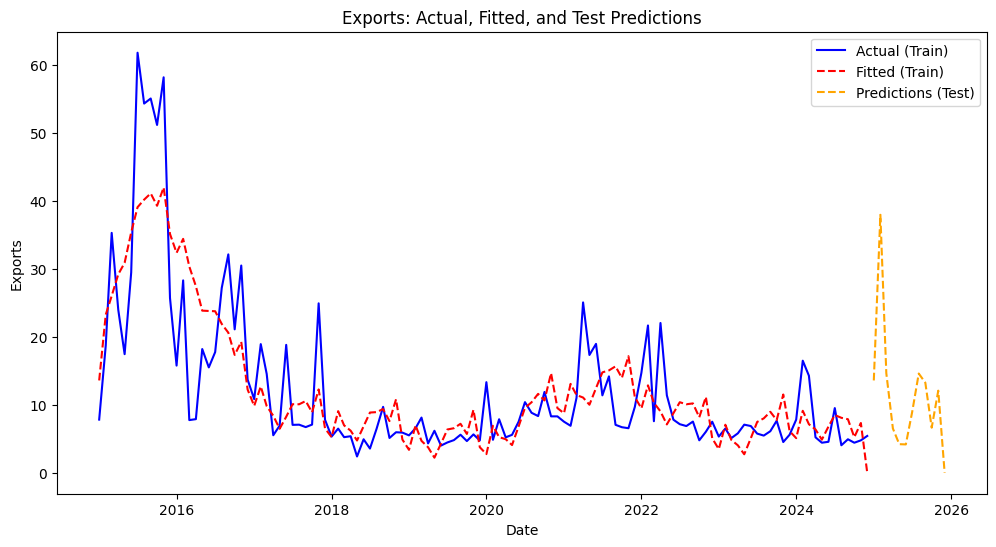

In [185]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(exports["date"], exports["exports"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(exports["date"], exports["fitted"],
         label="Fitted (Train)", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["exports"],
         label="Predictions (Test)", color="orange", linestyle="--")

plt.title("Exports: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Exports")
plt.legend()
plt.show()

### Adding some Fourier series to our model

We can try to add some Fourier series to our model.

In [186]:
from sklearn.base import BaseEstimator, TransformerMixin

class SplineFourierFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, period=12, df_spline=8, K=3, degree=3):
        """
        Custom transformer to generate spline (trend) + Fourier (seasonality) features.
        
        Parameters
        ----------
        period : int
            Seasonal period (e.g., 12 = monthly seasonality).
        df_spline : int
            Degrees of freedom for spline basis.
        K : int
            Number of Fourier harmonics.
        degree : int
            Degree of the splines (default cubic = 3).
        """
        self.period = period
        self.df_spline = df_spline
        self.K = K
        self.degree = degree
        self.spline_cols_ = []
        self.fourier_cols_ = []

    def fit(self, X, y=None):
        """Just record size for column naming."""
        n_basis = self.df_spline
        self.spline_cols_ = [f"spline_{i}" for i in range(n_basis)]
        self.fourier_cols_ = [f"sin_{k}" for k in range(1, self.K+1)] + \
                             [f"cos_{k}" for k in range(1, self.K+1)]
        return self

    def transform(self, X):
        """Generate features for trend (splines) and seasonality (Fourier)."""
        df = X.copy()

        # Ensure we have a sequential time index
        if "t" not in df.columns:
            df["t"] = np.arange(len(df))

        # Splines
        spline_basis = dmatrix(
            f"bs(t, df={self.df_spline}, degree={self.degree}, include_intercept=False)",
            {"t": df["t"]}, return_type="dataframe"
        )
        spline_basis.columns = self.spline_cols_ + ['month']

        # Fourier
        fourier = pd.DataFrame(index=df.index)
        for k in range(1, self.K+1):
            fourier[f"sin_{k}"] = np.sin(2 * np.pi * k * df["t"] / self.period)
            fourier[f"cos_{k}"] = np.cos(2 * np.pi * k * df["t"] / self.period)

        # Merge
        return pd.concat([df, spline_basis, fourier], axis=1)

    def get_feature_names_out(self, input_features=None):
        return self.spline_cols_ + self.fourier_cols_

In [208]:
# Creates the Transformer
feat_gen = SplineFourierFeatures(period=12, df_spline=15, K=0)

# Gera features
train_feats = feat_gen.fit_transform(exports_new)

# Fits an OLS model
formula = "exports ~ " + " + ".join(feat_gen.get_feature_names_out())
model_exports_fourier = smf.ols(formula, data=train_feats).fit()

In [209]:
model_exports_fourier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                exports   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     15.68
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           8.05e-20
Time:                        23:36:01   Log-Likelihood:                -396.17
No. Observations:                 120   AIC:                             822.3
Df Residuals:                     105   BIC:                             864.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5839      2.052      1.259      0.211      -1.486       6.653
spline_0       2.5839      2.052      1.259      0.211      -1.486       6.653
spline_1      43.8123      9.248      4.738      0.000      25.476      62.149
spline_2      38.5393      7.545      5.108      0.000      23.578      53.500
spline_3       5.7135      7.366      0.776      0.440      -8.893      20.320
spline_4      13.6385      6.545      2.084      0.040       0.661      26.617
spline_5      -2.5814      6.731     -0.384      0.702     -15.927      10.764
spline_6       2.2713      6.569      0.346      0.730     -10.754      15.297
spline_7      -0.4447      6.620     -0.067      0.947     -13.571      12.681
spline_8       1.3800      6.620      0.208      0.835     -11.746      14.506
spline_9       7.8828      6.569      1.200      0.233      -5.143      20.908
spline_10      8.5763      6.731      1.274      0.205      -4.770      21.922
spline_11      3.6893      6.545      0.564      0.574      -9.289      16.667
spline_12     -3.0466      7.366     -0.414      0.680     -17.653      11.560
spline_13      8.7046      7.545      1.154      0.251      -6.256      23.666
spline_14     -2.8856      9.248     -0.312      0.756     -21.222      15.451
==============================================================================
Omnibus:                       11.781   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               30.505
Skew:                           0.178   Prob(JB):                     2.38e-07
Kurtosis:                       5.444   Cond. No.                     2.54e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.85e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Visualizing the Predictions on Training Set

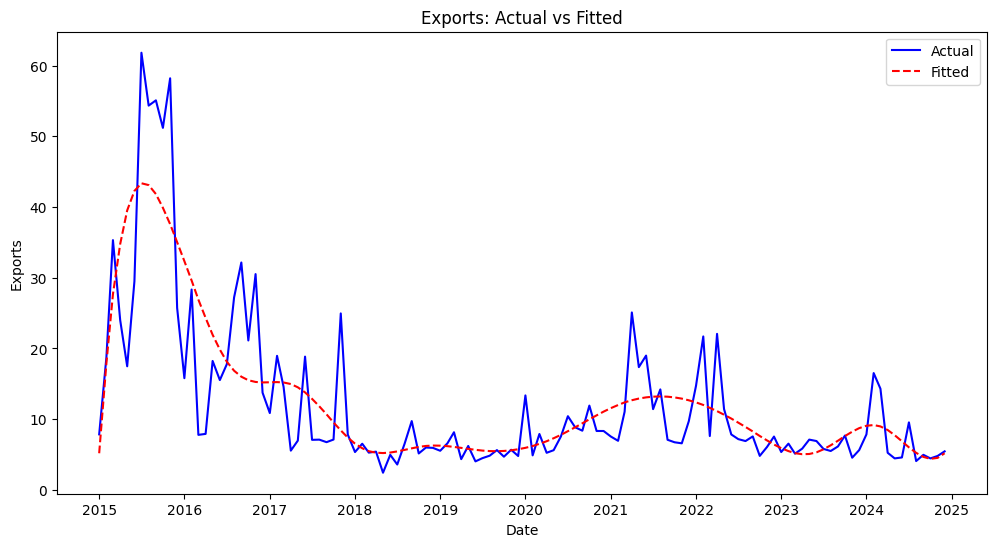

In [210]:
exports['fitted'] = model_exports_fourier.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(exports["date"], exports["exports"], label="Actual", color="blue")
plt.plot(exports["date"], exports["fitted"], label="Fitted", color="red", linestyle="--")

plt.title("Exports: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Exports")
plt.legend()
plt.show()

## Visualizing the Predictions on the Test set

In [211]:
test_df = create_future_dataframe()

test_feats = feat_gen.transform(test_df)
test_df["exports"] = model_exports_fourier.predict(test_feats)

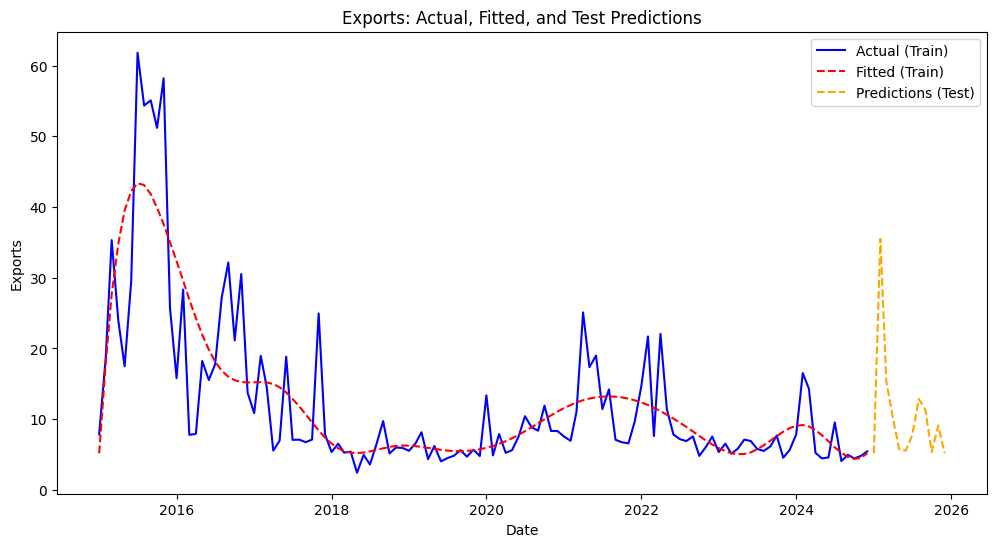

In [212]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(exports["date"], exports["exports"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(exports["date"], exports["fitted"],
         label="Fitted (Train)", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["exports"],
         label="Predictions (Test)", color="orange", linestyle="--")

plt.title("Exports: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Exports")
plt.legend()
plt.show()

## Caveat!

Once again, it's really hard to build a model for that kind of series and as we can see the predictions show up a spike at February 2025. That does not seem to be the expected pattern from the most recent data. 

But, as I said, that's an very rough approximation. 

And as we saw in the `01-EDA.ipynb` notebook, the Exports display a 0.45 linear correlation with our target variable. 

Which is a weak correlation. So that shouldn't damage very much our predictions for 2025.

## Saving the Predicitons Results

In [215]:
test_df[['date', 'exports']].to_csv("../../predictions/2025_exports.csv", index=False)

In [216]:
test_df[['date', 'exports']]

,date,exports
0,2025-01-01,5.167732
1,2025-02-01,35.505059
2,2025-03-01,15.319815
3,2025-04-01,10.151093
4,2025-05-01,5.701574
5,2025-06-01,5.537547
6,2025-07-01,7.723967
7,2025-08-01,12.848379
8,2025-09-01,11.342814
9,2025-10-01,5.349793
